<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install transformers

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 64.4 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 636 kB 82.3 MB/s 
     |████████████████████████████████| 3.3 MB 24.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 17.4 MB 217 kB/s 
     |████████████████████████████████| 1.9 MB 79.3 MB/s 
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to:
1. loosen the range of package versions you'

In [4]:
!nvidia-smi

Sun Oct  3 16:56:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive
import io, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [6]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWjFfXOpQF_Lhhwz8Sp5DTauJAEXNDQjx66Khyme5ASsCvDLtcqsBX0'

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


In [8]:
#model.save_pretrained('./amostra_news_integrada/bertimbau_base')
#tokenizer.save_pretrained('./amostra_news_integrada/bertimbau_base')
# .save_vocabulary('./amostra_news_integrada/bertimbau_base')
#tokenizer = AutoModel.from_pretrained('./amostra_news_integrada/bertimbau_base')
#model = AutoModel.from_pretrained('./amostra_news_integrada/bertimbau_base')

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [9]:
#%cd amostra_news_integrada
#!unzip amostra_news_integrada-20210815T184936Z-001.zip
#!ls -lh
#!ls  amostra_news_integrada/amostra_2
#!mkdir bertimbau_all_categ


In [10]:
#!mkdir ./bertimbau_all_categ/amostra_4
!ls 

 amostra_news_integrada			     figuras
 artigosWikibr.ipynb			     ResultadosExperimentos.ipynb
 Avaliação_Final_Enunciado.ipynb	     t_sne.ipynb
 bertimbau				     ULMFit_Noticias.ipynb
 bertimbau_resp				     ulmfit_resp
 classica_resp				     Untitled
 classificacaoNoticiasW2vec		     Untitled0.ipynb
'Cópia de BERTimbau_com_amostras.ipynb'      Untitled1.ipynb
'Cópia de BERTimbau_Testes.ipynb'	     Untitled2.ipynb
'Cópia de classificacaoNoticiasW2vec'	     Untitled3.ipynb
'Cópia de classificacaoNoticiasW2vec (1)'    Untitled4.ipynb
'Cópia de clusterizacaoNoticias_ngrams_v2'


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_resp' #'/content'


In [13]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 394 #limita os artigos em 128 tokens. BERTimbau base é limitado em 512 tokens por texto.
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 8
lr = 1e-6


def montaFields(MAX_SEQ_LEN):
  # Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
  label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
  text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
  fields = [('text', text_field),('label', label_field)]
  return [label_field, text_field, fields]

label_field, text_field, fields = montaFields(MAX_SEQ_LEN)





In [14]:
def tokenizaAmostra(source_folder, fields=fields, soTeste=False):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter, valid_iter = None, None
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  if soTeste == False:
    train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  return [train_iter, valid_iter, test_iter]



In [15]:
#print(vars(train[0]))
#print(vars(valid[0]))
#print(vars(test[0]))

## Modelo

In [16]:
'''É preciso informar o número de labels '''
class BERT(nn.Module):

    def __init__(self, qtd_categories):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        
        return loss, text_fea



## Treinamento

In [17]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def save_embedding(save_path, embedding):

    if save_path == None:
        return
    
    emb_dict = {'_': embedding}
    
    torch.save(emb_dict, save_path)
    print(f'Embedding saved to ==> {save_path}')

def load_embedding(load_path):

    if load_path==None:
        return
    
    emb_dict = torch.load(load_path, map_location=device)
    print(f'Embedding loaded from <== {load_path}')
    
    return emb_dict

def create_directory(path, directory):
  try:
    os.makedirs(path + '/' + directory)
  except FileExistsError:
    # directory already exists
    pass

In [18]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train() #habilita os valores dos pesos do modelo para treinamento
    for epoch in range(num_epochs):
        X = []  
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)  #carrega as categorias para pytorch         
            labels = labels.to(device) # disponibiliza para as GPU
            text = text.type(torch.LongTensor) #carrega os tokens do texto para pytorch        
            text = text.to(device) #disponibiliza para as GPU
            output = model(text, labels) #efetua o treinamento no modelo bert carregado
            loss, _ = output #obtem o valor da função loss do texto treinado

            optimizer.zero_grad() #limpa os gradientes do último treino (zera tudo)
            loss.backward() #calcula a derivada da função perda em relação aos parâmetros
            optimizer.step() #atualiza os pesos fazendo com que o otimizador dê um passo com base no gradiente dos parâmetros

            # update running values
            running_loss += loss.item() #acumula o valor da função loss
            global_step += 1
            #X.extend(_.tolist())
            # evaluation step - roda o modelo para o token de validação, obtém o valor da função loss e tira a média para o treinamento e validação.
            if global_step % eval_every == 0:
                model.eval() # seta as camadas dropout e batch normalization 
                with torch.no_grad():                    
                   
                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()
                        
                
                    

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                    
        #print(X)
        save_embedding(file_path + '/' + 'embedd.pt', X)
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    #save_embedding(file_path + '/' + 'embedd.pt', X)
    print('Finished Training!')
    

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
%%time
!NotebookApp.iopub_data_rate_limit = 1048576000000
qtd_categories=[10]
#token_train, token_valid, token_test = [],[],[]
id_planilha = [9.4]
dataset = [5]
n_epoca = 5
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
  create_directory(destination_folder,str(id_))
  file_path = destination_folder + "/"+str(id_)
  print(file_path)
  model = BERT(qtd_categories=qtd_categories[idx]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  train(model=model, 
      optimizer=optimizer,
      num_epochs=n_epoca,
      train_loader=tokens[0],
      valid_loader=tokens[1],
      eval_every=len(tokens[0]) // 2, #tamanho do dataset de treinamento / 2 (chão)
      file_path=file_path)
  print('Duracao:', datetime.now()-inicio)

/bin/bash: NotebookApp.iopub_data_rate_limit: command not found
./bertimbau_resp/9.4


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 5 inicio: 2021-10-02 00:15:09.150398
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [962/9625], Train Loss: 2.0392, Valid Loss: 1.9349
Model saved to ==> ./bertimbau_resp/9.4/model.pt
Model saved to ==> ./bertimbau_resp/9.4/metrics.pt
Epoch [1/5], Step [1924/9625], Train Loss: 1.3221, Valid Loss: 1.3900
Model saved to ==> ./bertimbau_resp/9.4/model.pt
Model saved to ==> ./bertimbau_resp/9.4/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.4/embedd.pt
Epoch [2/5], Step [2886/9625], Train Loss: 0.9058, Valid Loss: 0.6937
Model saved to ==> ./bertimbau_resp/9.4/model.pt
Model saved to ==> ./bertimbau_resp/9.4/metrics.pt
Epoch [2/5], Step [3848/9625], Train Loss: 0.5688, Valid Loss: 0.5806
Model saved to ==> ./bertimbau_resp/9.4/model.pt
Model saved to ==> ./bertimbau_resp/9.4/metrics.pt
Embedding saved to ==> ./bertimbau_resp/9.4/embedd.pt
Epoch [3/5], Step [4810/9625], Train Loss: 0.5424, Valid Loss: 0.4798
Model saved to ==> ./bertimba

## Valor da função LOSS na descida do gradiente 
por id de experimento registrado na planilha de controle

Model loaded from <== ./bertimbau_resp/9/metrics.pt
0.4962208903784945
Model loaded from <== ./bertimbau_resp/9.1/metrics.pt
0.37737944631560427
Model loaded from <== ./bertimbau_resp/9.2/metrics.pt
0.3606356496829733
Model loaded from <== ./bertimbau_resp/9.3/metrics.pt
0.40203540223861683
Model loaded from <== ./bertimbau_resp/9.4/metrics.pt
0.3834707951520983


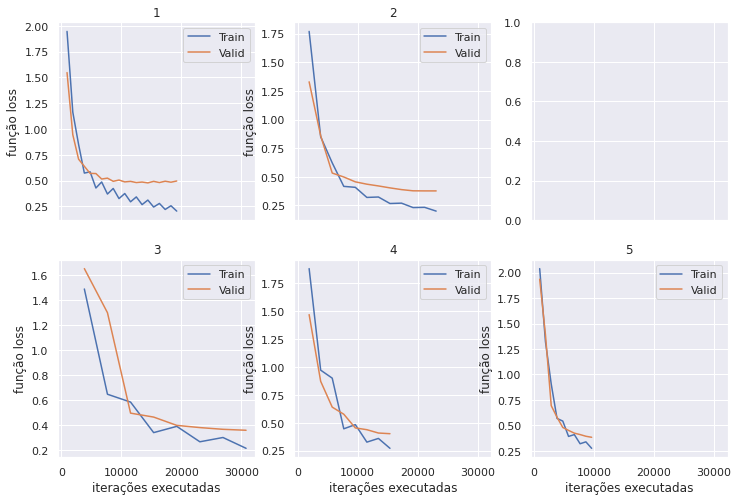

In [ ]:
id_planilha = [9,9.1,9.2,9.3,9.4]
fig, ax =plt.subplots(2,3, figsize=(12, 8), sharex=True)
corte=1
for idx, id_ in enumerate(id_planilha):
  if idx<=corte:
    i,j=0,idx
  else:
    i,j=1,idx-corte-1
  file_path = destination_folder + "/"+str(id_)
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(file_path + '/metrics.pt')
  sns.lineplot(x= global_steps_list, y = train_loss_list,  label = 'Train', legend='full', palette=palette, ax=ax[i,j])
  sns.lineplot(x = global_steps_list, y = valid_loss_list, label = 'Valid', legend='full', palette=palette, ax=ax[i,j])
  ax[i,j].set_title(idx+1) 
  ax[i,j].set_xlabel('iterações executadas')
  ax[i,j].set_ylabel('função loss')
  print(valid_loss_list[-1])
  '''plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino id ' + str(id_)
  plt.legend()
  plt.show() '''

### Avaliação
* https://towardsdatascience.com/evaluating-categorical-models-e667e17987fd
* https://towardsdatascience.com/evaluating-categorical-models-ii-sensitivity-and-specificity-e181e573cff8
* https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5
* https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
* https://towardsdatascience.com/matthews-correlation-coefficient-when-to-use-it-and-when-to-avoid-it-310b3c923f7e
* https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2 
*https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
* https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c
* https://thedatascientist.com/performance-measures-cohens-kappa-statistic/
* Material de aula do Professor André
* Material do curso MicroSoft
* Predictive Accuracy: A Misleading Performance Measure for Highly Imbalanced Data (sas_metrics.pdf) Paper 942-2017 (Josephine S Akosa, Oklahoma State University)


VP = VERDADEIRO POSITIVO<br>
VN = VERDADEIRO NEGATIVO<br>
FP = FALSO POSITIVO<br>
FN = FALSON NEGATIVO<br>
TVP = TAXA DE VERDADEIRO POSITIVO<br>
TVN = TAXA DE VERDADEIRO NEGATIVO<br>
TFP = TAXA DE FALSO POSITIVO<br>
TFN = TAXA DE FALSO NEGATIVO<br>

Métricas utilizadas:<br>

* **Acurácia:** proporção de classificações corretas feitas pelo modelo.<br>
        Acurácia = (VP + VN)/(VP+VN+VP+VN)<br>

* **Precisão:** proporção correta de classificação feita para uma determinada classe.<br>
        Precisão = (VP)/(VP + FP)

* **Revocação ou Sensibilidade:** proporção de classificações corretas de VP feitas para uma determinada classe considerando todas as instâncias do dataset de testes.<br>
      Revocação = TVP = (VP)/(VP+FN)

* **Especificidade:** proporção de classificações corretas de VN feitas para uma determinada classe considerando todas as instâncias do dataset de testes.
      Especificidade = TVN = (VN)/(VN + FP)

* **Suporte:** quantidade de instâncias de uma determinada classe no dataset de testes.

**Para o DataSet 3 - dados desbalanceados**

* **F1 é a média harmônica da precisão e da revocação.<br>

      F1 = (2 * VP) / (2 * VP + FP + FN)
* **MCC:** é o coeficiente de correlação Matthews que é utilizado para classes com tamanhos diferentes. Possui escala entre -1 e 1, sendo que 1 indica uma perfeita predição, 0 representa uma predição aleatória e -1 indica discordância total dos valores preditos e os valores verdadeiros.  

      MCC = (VP*VN - FP*FN) / (SQRT(VP+FP)*(VP+FN)*(VN+FP)*(VN+FN)
      

* **Kappa Score - Cohen's Kappa Coefficient** informa quão melhor o classificador está se saindo em relação ao desempenho de um classificador que simplesmente adivinha aleatoriamente de acordo com a frequência de cada classe:

      k = (Po - Pe)/(1-Pe) = 1 - (1 - Po)/(1 - Pe)

Po é a concordancia observada e Pe é a concordância esperada. O Kappa de Cohen é sempre menor ou igual a 1, sendo que valores menores ou iguais a zero indicam que o classificador é inútil. Quanto mais próximo de 1, indica que o classificador gera uma concordância quase perfeita.

* **Média Geométrica (G-mean)** é uma métrica que mede o equilíbrio entre o desempenho de classificação tanto na classe majoritária quanto na minoritária. Um índice baixo é uma indicação de mau desempenho na classificação dos casos positivos, mesmo que os casos negativos sejam corretamente classificados como tal. Ela é importante para prever o sobreajustamento da classe negativa e o subajustamento da classe positiva. Como nosso dataset não possui classes binárias, a fórmula de cálculo será como se segue (material de aula do Prof. André):

      G-mean = $(\pi_{i=1}^{c}Revocacao_{i})^{1/c}$ 




  



In [25]:
def calcula_especificidade(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = np.sum(VN)/(np.sum(VN) + np.sum(FP))
  return TVN

In [24]:
def calcula_especificidade_porClasse(matriz_confusao):
  FP = matriz_confusao.sum(axis=0) - np.diag(matriz_confusao) 
  FN = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
  VP = np.diag(matriz_confusao)
  VN = matriz_confusao.sum() - (FP + FN + VP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  VP = VP.astype(float)
  VN = VN.astype(float)
  TVN = (VN)/(VN + FP)
  return TVN

In [23]:
def calcula_GMean_multiclass(revocacao):
   revoc = np.array(revocacao)
   GMean = revoc.prod()**(1.0/len(revoc))
   return GMean  
   

In [22]:
def elabora_relatorio_metricas(report, matriz_confusao):
  espec = calcula_especificidade_porClasse(matriz_confusao) # calcula o valor da especificidade para cada classe
  dfrep = pd.DataFrame(report).transpose() #transforma o conteúdo do classification_report em um dataframe pandas
  dfrep_a = dfrep[:-3].copy() # separa as métricas de cada classe do valor da acurácia geral do modelo
  dfrep_a['specificity'] = espec # inclui no dataframe o valor da especificidade
  dfrep_b  = dfrep[dfrep.index=='accuracy'].copy() #obtem do dataframe somente o valor da acurácia
  dfrep_b['specificity']=calcula_especificidade(matriz_confusao) # inclui o valor da especificidade geral de todas as classes
  metricas = ['precision', 'recall', 'specificity', 'f1-score', 'support'] #organiza as métricas na ordem desejada
  df = pd.concat([dfrep_a[metricas],dfrep_b[metricas]],sort=False) #concatena todos os valores em um único dataframe
  df['support'] = df['support'].astype('int')
  return df



In [27]:
def evaluate(model, test_loader, report=True):
    y_pred = []
    y_true = []
    X = []


    #obtem os valores preditos e os valores de teste
    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)  #carrega as classes para uma estrutura pytorch         
                labels = labels.to(device)  #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                text = text.type(torch.LongTensor)    #carrega o texto para uma estrutura pytorch
                text = text.to(device)          #carrega a estrutura pytorch para GPU (se houver, foi testado anteriormente)
                output = model(text, labels)   #submete o texto e a label da classe ao modelo

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())  #obtem do pytorch de saída do modelo o valor predito.
                y_true.extend(labels.tolist()) #obtem do pytorch de teste  valor real.
                #print(_)
                X.extend(output.tolist())
    if report==False:
      return [X, y_true, y_pred]

    print('Classification Report:')
    n_classe = np.max(y_true)+1 #obtem o número de classes
    report = classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4, output_dict=True) #gera o relatório de métricas
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe)) #gera a matriz de confusao
    report = elabora_relatorio_metricas(report, cm) #inclui no relatorio a especificidade
    print(report)

    cohen_kappa = cohen_kappa_score(y_true, y_pred,labels=np.arange(0,n_classe))
    ccmatheus = matthews_corrcoef(y_true, y_pred)
    
    print("Acurácia:",accuracy_score(y_true, y_pred))
    print('Acurácia balanceada:',balanced_accuracy_score(y_true, y_pred))
    print('GMean:', calcula_GMean_multiclass(report['recall']))
    print('Cohen Kappa Score:', cohen_kappa)
    print('Coef. Correlacao Matheus:', ccmatheus)
    print('******************************************************************')
    
    
    #ax= plt.subplot()
    #sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")
    #ax.set_title('Confusion Matrix')
    #ax.set_xlabel('Predicted Labels')
    #ax.set_ylabel('True Labels')
    return [X, y_true, y_pred, report]

def imprimeROC_PrecisonRecall_curvas(y_teste,predicted_prob):
  classes = np.unique(y_teste)
  y_test_array = pd.get_dummies(y_teste, drop_first=False).values
  fig, ax = plt.subplots(figsize=(12,8),nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='Taxa Falso Positivo ', 
            ylabel="Taxa Verdadeiro Positivo (Revocação)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()



id_planilha: 9


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_resp/9/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.876847  0.890000     0.985507  0.883375      200
1          0.908537  0.748744     0.991309  0.820937      199
2          0.960199  0.979695     0.995370  0.969849      197
3          0.912195  0.886256     0.989498  0.899038      211
4          0.905473  0.928571     0.989011  0.916877      196
5          0.734234  0.853403     0.965975  0.789346      191
6          0.870813  0.892157     0.984311  0.881356      204
7          0.961353  0.934272     0.995327  0.947619      213
8          0.882682  0.897727     0.987993  0.890141      176
9          0.873134  0.847826     0.990487  0.860294      138
accuracy   0.887273  0.887273     0.987475  0.887273        0
Acurácia: 0.8872727272727273
Acurácia balanceada: 0.8858652167066724
GMean: 0.8841463990181565
Cohen Kappa Score: 0.8745953186655363
Coef. Correlacao Matheus: 0.874905023824279
******

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

Model loaded from <== ./bertimbau_resp/9.1/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.944134  0.845000     0.994203  0.891821      200
1          0.841346  0.879397     0.980881  0.859951      199
2          0.974874  0.984772     0.997106  0.979798      197
3          0.921182  0.886256     0.990665  0.903382      211
4          0.915842  0.943878     0.990168  0.929648      196
5          0.879397  0.916230     0.986159  0.897436      191
6          0.888325  0.857843     0.987217  0.872818      204
7          0.953271  0.957746     0.994159  0.955504      213
8          0.828431  0.960227     0.979989  0.889474      176
9          0.891667  0.775362     0.992725  0.829457      138
accuracy   0.903896  0.903896     0.989322  0.903896        0
Acurácia: 0.9038961038961039
Acurácia balanceada: 0.9006711607907849
GMean: 0.8990293107798394
Cohen Kappa Score: 0.8930736013921975
Coef. Correlacao Matheus: 0.8933214897972782
***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

Model loaded from <== ./bertimbau_resp/9.2/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.919192  0.910000     0.990725  0.914573      200
1          0.856436  0.869347     0.983198  0.862843      199
2          0.970297  0.994924     0.996528  0.982456      197
3          0.930348  0.886256     0.991832  0.907767      211
4          0.910000  0.928571     0.989589  0.919192      196
5          0.934066  0.890052     0.993080  0.911528      191
6          0.876847  0.872549     0.985474  0.874693      204
7          0.953488  0.962441     0.994159  0.957944      213
8          0.843434  0.948864     0.982276  0.893048      176
9          0.870968  0.782609     0.991046  0.824427      138
accuracy   0.908052  0.908052     0.989784  0.908052        0
Acurácia: 0.908051948051948
Acurácia balanceada: 0.9045612966476992
GMean: 0.9032405223490759
Cohen Kappa Score: 0.8976953261874443
Coef. Correlacao Matheus: 0.8978193542404511
****

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

Model loaded from <== ./bertimbau_resp/9.3/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.929348  0.855000     0.992464  0.890625      200
1          0.811321  0.864322     0.976825  0.836983      199
2          0.970149  0.989848     0.996528  0.979899      197
3          0.934343  0.876777     0.992415  0.904645      211
4          0.918782  0.923469     0.990746  0.921120      196
5          0.809524  0.890052     0.976932  0.847880      191
6          0.889474  0.828431     0.987798  0.857868      204
7          0.957346  0.948357     0.994743  0.952830      213
8          0.832512  0.960227     0.980560  0.891821      176
9          0.882353  0.760870     0.992166  0.817121      138
accuracy   0.892987  0.892987     0.988110  0.892987        0
Acurácia: 0.892987012987013
Acurácia balanceada: 0.8897353336742541
GMean: 0.8878424373079596
Cohen Kappa Score: 0.8809404786459971
Coef. Correlacao Matheus: 0.8812397815712
*******

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

Model loaded from <== ./bertimbau_resp/9.4/model.pt
Classification Report:
          precision    recall  specificity  f1-score  support
0          0.912371  0.885000     0.990145  0.898477      200
1          0.882653  0.869347     0.986674  0.875949      199
2          0.970149  0.989848     0.996528  0.979899      197
3          0.930000  0.881517     0.991832  0.905109      211
4          0.892683  0.933673     0.987276  0.912718      196
5          0.865979  0.879581     0.985006  0.872727      191
6          0.884058  0.897059     0.986055  0.890511      204
7          0.962085  0.953052     0.995327  0.957547      213
8          0.852041  0.948864     0.983419  0.897849      176
9          0.892562  0.782609     0.992725  0.833977      138
accuracy   0.905455  0.905455     0.989495  0.905455        0
Acurácia: 0.9054545454545454
Acurácia balanceada: 0.9020548457040034
GMean: 0.9008087557257412
Cohen Kappa Score: 0.8948032158057906
Coef. Correlacao Matheus: 0.8949341092847051
***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


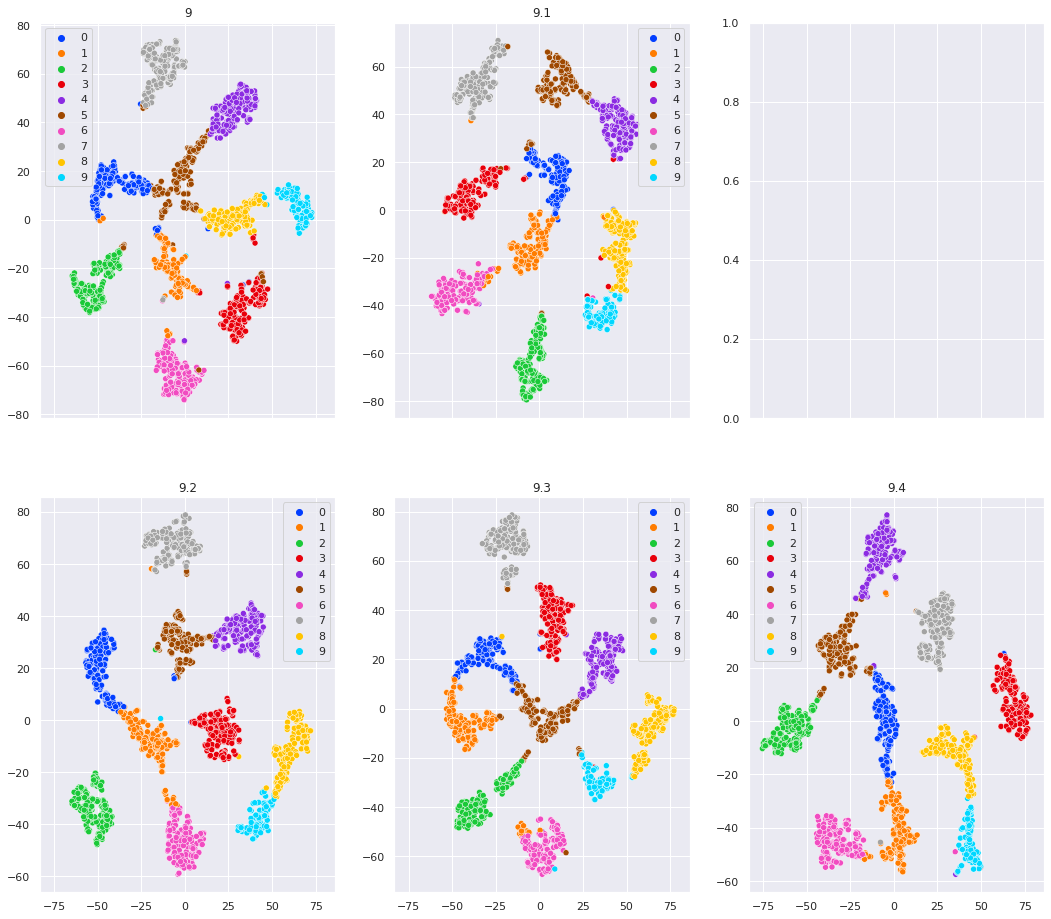

In [33]:
#%%time    
rep = []
qtd_categories=[10,10,10,10,10]
id_planilha = [9,9.1,9.2,9.3,9.4]
MAX_SEQ_LEN = [128,256,512,256,394]
dataset = [5,5,5,5,5]
fig, ax =plt.subplots(2,3, figsize=(18, 16), sharex=True)
corte=1
for idx, (id_, amostra) in enumerate(zip(id_planilha,dataset)):
      print('id_planilha:', id_)
      label_field, text_field, fields = montaFields(MAX_SEQ_LEN[idx])
      tokens = tokenizaAmostra(source_folder+str(amostra),soTeste=True)
      best_model = BERT(qtd_categories=qtd_categories[idx]).to(device)
      load_checkpoint(destination_folder+"/"+str(id_) + '/model.pt', best_model)
      X_saida_teste, y_true, y_pred, df = evaluate(best_model, tokens[2]) #tokens[2] é o dataset de teste
      rep.append(df)
      X_saida_teste = np.array(X_saida_teste)
      tsne = TSNE(n_components=2,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
      X_embedded = tsne.fit_transform(X_saida_teste)
      if idx<=corte:
        i,j=0,idx
      else:
        i,j=1,idx-corte-1
      sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette, ax=ax[i,j])
      ax[i,j].set_title(id_)

      


In [35]:
def categoria(nro):
  cat = ['politica', 'economia', 'esporte', 'mundo', 'ilustrada', 'midia', 'tecnologia', 'educação', 'saude', 'ciencia']
  return cat[nro]
cat = [categoria(i) for i in range(0,10)]
cat.append('acurácia')
for idx, df in enumerate(rep):
  dfx = df.copy()
  print(idx)
  dfx['categoria'] = cat
  dfx['precision'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in dfx['precision']], index = df.index)
  dfx['recall'] = pd.Series([" & ${0:.2f}\%$  ".format(val * 100) for val in dfx['recall']], index = df.index)
  dfx['specificity'] = pd.Series([" & ${0:.2f}\%$ ".format(val * 100) for val in dfx['specificity']], index = df.index)
  dfx['f1-score'] = pd.Series([" & ${0:.2f}\%$  & ".format(val * 100) for val in dfx['f1-score']], index = df.index)
  dfx[['categoria', 'precision', 'recall', 'specificity','f1-score','support']]
  print(dfx[['categoria', 'precision', 'recall', 'f1-score','support']])

0
           categoria       precision          recall          f1-score  support
0           politica   & $87.68\%$     & $89.00\%$     & $88.34\%$  &       200
1           economia   & $90.85\%$     & $74.87\%$     & $82.09\%$  &       199
2            esporte   & $96.02\%$     & $97.97\%$     & $96.98\%$  &       197
3              mundo   & $91.22\%$     & $88.63\%$     & $89.90\%$  &       211
4          ilustrada   & $90.55\%$     & $92.86\%$     & $91.69\%$  &       196
5              midia   & $73.42\%$     & $85.34\%$     & $78.93\%$  &       191
6         tecnologia   & $87.08\%$     & $89.22\%$     & $88.14\%$  &       204
7           educação   & $96.14\%$     & $93.43\%$     & $94.76\%$  &       213
8              saude   & $88.27\%$     & $89.77\%$     & $89.01\%$  &       176
9            ciencia   & $87.31\%$     & $84.78\%$     & $86.03\%$  &       138
accuracy    acurácia   & $88.73\%$     & $88.73\%$     & $88.73\%$  &         0
1
           categoria       precision

In [76]:
frame=[]
cat = [categoria(i) for i in range(0,10)]
cat.append('acuracia')
for idx, df in enumerate(rep):
  dfx = df[['precision', 'recall', 'f1-score','support']].copy()
  dfx = dfx[dfx.index!='accuracy']
  frame2 = []
  for col in dfx.columns:
    dct = {'categoria':cat,
         'metrica': [col for i in range(0,len(cat))],
         'valor':df[col].tolist(),
         'categoria': cat ,
         'experimento':[idx+1 for i in range(0,len(cat))]
         }
    dfy = pd.DataFrame(dct)     
    frame2.append(dfy)
  frame.append(pd.concat(frame2, sort=False))  
dfy = pd.concat(frame,sort=False)  

In [97]:
 dfy = dfy[dfy['categoria']!='acuracia']
 dfy = dfy[dfy['metrica']!='support']
 dfy['valor'] = dfy['valor']*100

In [98]:
dfy.head()

,categoria,metrica,valor,experimento
0,politica,precision,87.684729,1
1,economia,precision,90.853659,1
2,esporte,precision,96.019900,1
3,mundo,precision,91.219512,1
4,ilustrada,precision,90.547264,1


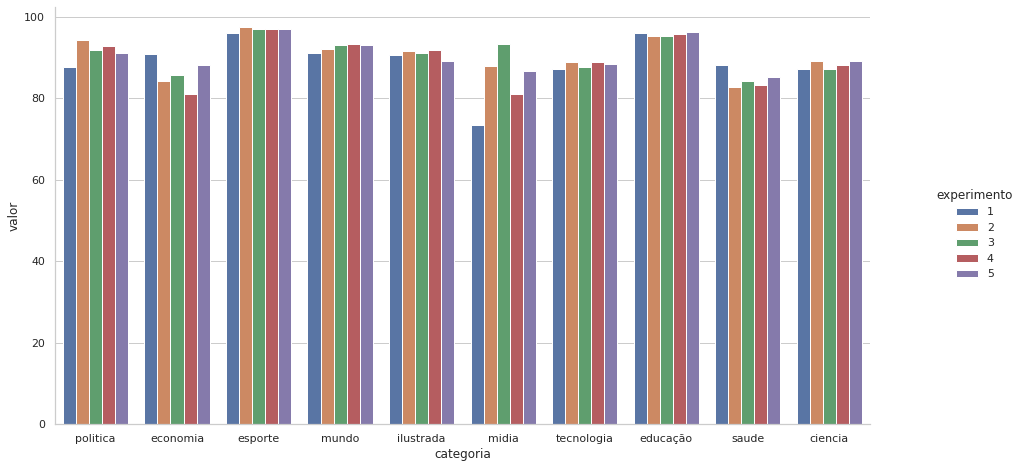

In [137]:
sns.set_theme(style="whitegrid")
sns.color_palette("Paired")
dfGraph = dfy[dfy['metrica']=='precision']
#fig, ax =plt.subplots( sharex=True)
g = sns.catplot(x='categoria', y='valor', hue='experimento', data=dfGraph, kind='bar', height=8.0)
g.fig.set_size_inches(15,8)
g.fig.subplots_adjust(top=0.81,right=0.86)  
'''sns.barplot(x= 'categoria', y = 'valor', hue='experimento', data=dfGraph, ax = ax).set_title("Valor da Precisão em cada um dos experimentos")
for idx, bar in enumerate(ax.patches):
  ax.annotate(format(bar.get_height(),'.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 6),
                   textcoords='offset points')'''
for item in ax.get_xticklabels():
    item.set_rotation(90)
sns.set(rc={'figure.figsize':(22,8)})

In [ ]:
#X, y_true, y_pred = resp
#X = X.cpu().numpy()
#X.shape
#y = y_true.cpu().numpy()
id_=9
X = load_embedding(destination_folder+"/"+str(id_) + '/embedd.pt')
X = X['_']
X_saida_treino = np.array(X)

Embedding loaded from <== ./bertimbau_resp/9/embedd.pt


In [ ]:
qtd_categories=10
MAX_SEQ_LEN = 128
dataset = 5

label_field, text_field, fields = montaFields(MAX_SEQ_LEN)
tokens = tokenizaAmostra(source_folder+str(dataset),soTeste=True)

In [ ]:
with np.printoptions(threshold=np.inf):
  for (text, labels), _ in tokens[2]:
    print(text[0:6])
    break
    

tensor([[  101,   177,  6279,  5271, 20696,  6050,   484,  3127,  3660,   370,
           356,   118, 14258,   113,  1426,   114,   179,   327,   981,   125,
         12347, 22281,  4584,   107, 22002,  9650,   107,  5076, 22303,   123,
           681,  3996,   173,  5899,  1490,   625,   347,  1160,  1461,   117,
           107, 22002,  9650,  9072,   107,   117,   344,  1513,   117,   202,
           995, 11445,   119, 18068,  6181,  5872,   107, 22002,  9650,  9072,
           107,   117,   146,  1130,  5710,   222,  2277,  1565,   681,  2760,
           117,   173,   179,   146,   179,   253,  5717,   221,   146,  2357,
           253,   146,   179,   146,  6844,   107,  5003,   107,   117,   271,
           538,  1960,   125,  7520,   119,  5394,  7620,   179,  1981,  2962,
           146,  1130,   325,  2898,   180,  4657,   253,   179,  9288,   125,
          1110,   117,  4870,  5969,   125, 10779, 14828,   117,  6224, 16337,
           240,  6362,   119, 22002,  9650,  9072,  

In [ ]:
id_amostra=5
dfTeste = pd.read_csv('./amostra_news_integrada/amostra_'+str(id_amostra)+'/test.csv')

In [ ]:
'''for i in range(0,dfTeste.shape[0]):
  texto = dfTeste['text'][i]
  texto = texto.split(' ')
  #texto = ' '.join(texto)
  if len(texto) < 128:
    print(i)
    break'''
texto = dfTeste['text'][5] 
len(texto.split(' '))

85

In [ ]:
tk_texto = tokenizer.tokenize("[CLS] " + texto + "[SEP]")
len(tk_texto)

122

In [ ]:
#y_treino
id_amostra = 5
df = pd.read_csv('./amostra_news_integrada/amostra_'+str(id_amostra)+'/train.csv')
y = df['category_nro'].tolist()


Treino

In [ ]:
tsne = TSNE(n_components=2,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
X_embedded = tsne.fit_transform(X_saida_treino)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 15396 samples in 0.019s...
[t-SNE] Computed neighbors for 15396 samples in 1.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15396
[t-SNE] Computed conditional probabilities for sample 2000 / 15396
[t-SNE] Computed conditional probabilities for sample 3000 / 15396
[t-SNE] Computed conditional probabilities for sample 4000 / 15396
[t-SNE] Computed conditional probabilities for sample 5000 / 15396
[t-SNE] Computed conditional probabilities for sample 6000 / 15396
[t-SNE] Computed conditional probabilities for sample 7000 / 15396
[t-SNE] Computed conditional probabilities for sample 8000 / 15396
[t-SNE] Computed conditional probabilities for sample 9000 / 15396
[t-SNE] Computed conditional probabilities for sample 10000 / 15396
[t-SNE] Computed conditional probabilities for sample 11000 / 15396
[t-SNE] Computed conditional probabilities for sample 12000 / 15396
[t-SNE] Computed conditional probabilities for sam

In [ ]:
print(X_embedded.shape, len(y))

(15396, 2) 15396


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


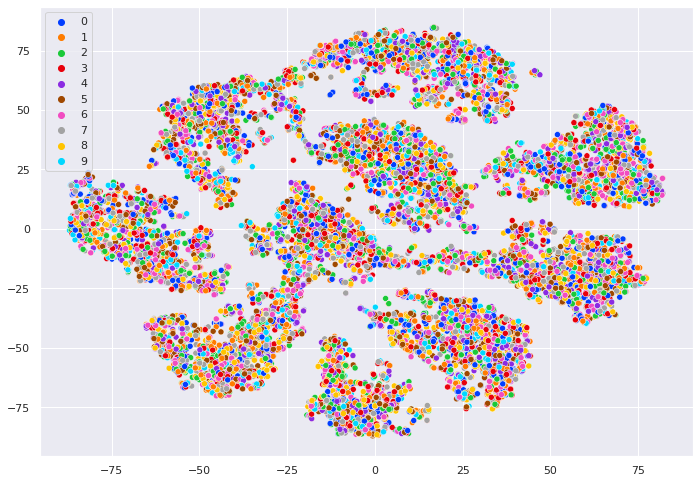

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)


IndexError: ignored

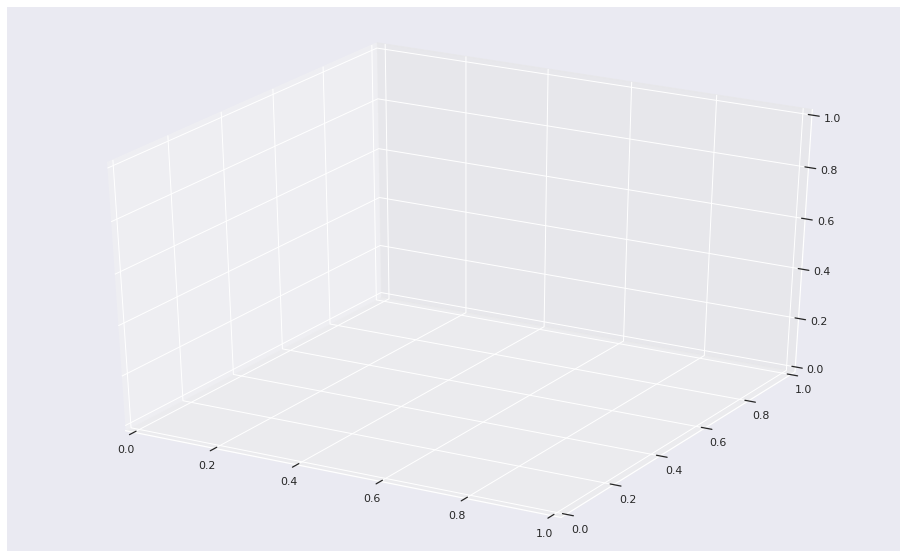

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_embedded[:,0], 
    ys=X_embedded[:,1], 
    zs=X_embedded[:,2], 
    c=y 
    
)
ax.set_xlabel('x-one')
ax.set_ylabel('x-two')
ax.set_zlabel('x-three')
plt.legend()
plt.show()

Teste

In [ ]:
X_saida_teste = np.array(X_saida_teste)
print(X_saida_teste.shape)

In [ ]:
tsne = TSNE(n_components=2,perplexity=20, metric='euclidean', n_iter=1000, random_state=27, verbose=1)
X_embedded = tsne.fit_transform(X_saida_teste)

In [ ]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
